# Facescrub 100 epochs

In [ ]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [ ]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import FaceScrubDataset, FACESCRUB_MEAN, FACESCRUB_STD
from torch.utils.data import DataLoader

### Set hyperparameters

In [ ]:
learning_rate = 0.001
epochs = 100
batch_size = 256
output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/facescrub_clear_100_epochs"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/facescrub_blur_100_epochs"

os.makedirs(output_dir_clear, exist_ok=True)
os.makedirs(output_dir_blur, exist_ok=True)

### Define transforms

In [ ]:
prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load FaceScrub dataset

In [ ]:
train_dataset = FaceScrubDataset(train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = FaceScrubDataset(train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = FaceScrubDataset(train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Dev set size: 23488
Val set size: 2936
Test set size: 2936


### Create ResNet18 model

In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clear_model = AlexNetSup(num_classes=297).to(device)
blur_model = AlexNetSup(num_classes=297).to(device)

criterion = nn.CrossEntropyLoss()
clear_optimizer = torch.optim.Adam(clear_model.parameters(), lr=learning_rate, weight_decay=1e-5)
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)
clear_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=clear_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
clear_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=clear_optimizer, T_max=(epochs - 2) * steps)
clear_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=clear_optimizer,
                                                            schedulers=[clear_warmup_scheduler, clear_decay_scheduler],
                                                            milestones=[2*steps+1])
blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [ ]:
!pip install kornia

In [ ]:
from utils import add_blur_with

# Assuming criterion is defined (e.g., criterion = nn.CrossEntropyLoss())

# Initialize metrics for plotting
clear_train_correct, clear_val_correct = [], []
blur_train_correct, blur_val_correct = [], []
clear_train_loss_list, clear_val_loss_list = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs_clear = []
logs_blur = []

clear_model.eval()
blur_model.eval()

# Training metrics initialization
clear_train_corr, blur_train_corr, total_train = 0, 0, 0
clear_train_loss, blur_train_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        blurred_images = blurred_images.to(device)

        # Get predictions from both models
        clear_y_pred = clear_model(images)
        blur_y_pred = blur_model(blurred_images)

        # Calculate loss values
        clear_loss = criterion(clear_y_pred, labels)
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_train_loss += clear_loss.item() * labels.size(0)
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        clear_train_corr += (clear_predicted == labels).sum().item()
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
clear_train_accuracy = (clear_train_corr / total_train) * 100
blur_train_accuracy = (blur_train_corr / total_train) * 100
clear_train_loss /= total_train
blur_train_loss /= total_train

# Validation metrics initialization
clear_val_corr, blur_val_corr, total_val = 0, 0, 0
clear_val_loss, blur_val_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        clear_y_val_pred = clear_model(images)
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        clear_loss = criterion(clear_y_val_pred, labels)
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_val_loss += clear_loss.item() * labels.size(0)
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_val_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        clear_val_corr += (clear_predicted == labels).sum().item()
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
clear_val_accuracy = (clear_val_corr / total_val) * 100
blur_val_accuracy = (blur_val_corr / total_val) * 100
clear_val_loss /= total_val
blur_val_loss /= total_val

# Save results for plotting
clear_train_correct.append(clear_train_accuracy)
clear_val_correct.append(clear_val_accuracy)
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
clear_train_loss_list.append(clear_train_loss)
blur_train_loss_list.append(blur_train_loss)
clear_val_loss_list.append(clear_val_loss)
blur_val_loss_list.append(blur_val_loss)

# Log entry with both accuracy and loss values
clear_log_entry = (f"Epoch 0/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss:.4f}")
print(clear_log_entry)
logs_clear.append(clear_log_entry)

blur_log_entry = (f"Epoch 0/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs_blur.append(blur_log_entry)

Epoch 0/100, Clear train acc: 0.3820%, Clear train loss: 5.7001, Clear val acc: 0.28%, Clear val loss: 5.6991
Epoch 0/100, Blur train acc: 0.3134%, Blur train loss: 5.6959, Blur val acc: 0.39%, Blur val loss: 5.7032


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    clear_model.train()
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum, blur_train_loss_sum = 0.0, 0.0
    train_samples = 0

    for _, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 20:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch < 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch < 60:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch < 80:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        else:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()
        blur_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)
        blur_logits = blur_model(blurred_images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        blur_loss.backward()
        clear_optimizer.step()
        blur_optimizer.step()
        clear_combined_scheduler.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    blur_model.eval()
    clear_train_corr, blur_train_corr, total_train = 0, 0, 0
    clear_train_loss_eval, blur_train_loss_eval = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            if epoch < 20:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            elif epoch < 40:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            elif epoch < 60:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            elif epoch < 80:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            else:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
            blurred_images, labels = blurred_images.to(device), labels.to(device)
            images = images.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(blurred_images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    blur_train_accuracy = (blur_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr, blur_val_corr, total_val = 0, 0, 0
    clear_val_loss_sum, blur_val_loss_sum = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    blur_val_accuracy = (blur_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    blur_train_loss_list.append(blur_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss_avg:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs_blur.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_clear = {
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
            'train_accuracy': clear_train_accuracy,
            'train_loss': clear_train_loss_epoch,  # Optionally log training loss from the training loop
        }
        torch.save(checkpoint_clear, clear_checkpoint_path)

        blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/100, Clear train acc: 1.5582%, Clear train loss: 5.5323, Clear val acc: 2.06%, Clear val loss: 5.5084
Epoch 1/100, Blur train acc: 1.5453%, Blur train loss: 5.5300, Blur val acc: 1.17%, Blur val loss: 5.5312
Epoch 2/100, Clear train acc: 5.7134%, Clear train loss: 4.8427, Clear val acc: 6.11%, Clear val loss: 4.7832
Epoch 2/100, Blur train acc: 4.3570%, Blur train loss: 4.9441, Blur val acc: 2.91%, Blur val loss: 5.3051
Epoch 3/100, Clear train acc: 16.6252%, Clear train loss: 3.9055, Clear val acc: 17.51%, Clear val loss: 3.8305
Epoch 3/100, Blur train acc: 11.1135%, Blur train loss: 4.3047, Blur val acc: 7.42%, Blur val loss: 5.3260
Epoch 4/100, Clear train acc: 31.7394%, Clear train loss: 3.0445, Clear val acc: 35.44%, Clear val loss: 2.8830
Epoch 4/100, Blur train acc: 22.7121%, Blur train loss: 3.5623, Blur val acc: 10.76%, Blur val loss: 5.3067
Epoch 5/100, Clear train acc: 45.1236%, Clear train loss: 2.3536, Clear val acc: 47.44%, Clear val loss: 2.2693
Epoch 5/100, Blur

## Test model after training

In [ ]:
clear_model.eval()
blur_model.eval()
clear_test_correct, blur_test_correct, total_test = 0, 0, 0

with torch.no_grad():
    for _, images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        clear_outputs = clear_model(images)
        blur_outputs = blur_model(images)
        clear_predicted = torch.max(clear_outputs.data, 1)[1]
        blur_predicted = torch.max(blur_outputs.data, 1)[1]
        clear_test_correct += (clear_predicted == labels).sum().item()
        blur_test_correct += (blur_predicted == labels).sum().item()
        total_test += labels.size(0)

clear_test_accuracy = (clear_test_correct / total_test) * 100
blur_test_accuracy = (blur_test_correct / total_test) * 100

# Add test results to log file
clear_log_entry = (f"Clear Test Accuracy: {clear_test_accuracy:.4f}")
print(clear_log_entry)
logs_clear.append(clear_log_entry)
blur_log_entry = (f"Blur Test Accuracy: {blur_test_accuracy:.4f}%")
print(blur_log_entry)
logs_blur.append(blur_log_entry)

Clear Test Accuracy: 88.7784
Blur Test Accuracy: 84.5881%


### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir_clear}/training_log.txt", 'w') as log_file:
    for log_entry in logs_clear:
        log_file.write(log_entry + '\n')

with open(f"{output_dir_blur}/training_log.txt", 'w') as log_file:
    for log_entry in logs_blur:
        log_file.write(log_entry + '\n')

clear_metrics = {
    'clear_train_correct': clear_train_correct,
    'clear_val_correct': clear_val_correct,
    'clear_train_loss_list': clear_train_loss_list,
    'clear_val_loss_list': clear_val_loss_list
}
blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir_clear}/metrics.pkl", "wb") as clear_metrics_file:
    pickle.dump(clear_metrics, clear_metrics_file)

with open(f"{output_dir_blur}/metrics.pkl", "wb") as blur_metrics_file:
    pickle.dump(blur_metrics, blur_metrics_file)

### Plot clear loss and accuracy

In [2]:
import pickle

output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_clear_100_epochs"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"

with open(f"{output_dir_clear}/metrics.pkl", "rb") as metrics_file:
    clear_metrics = pickle.load(metrics_file)

clear_train_correct = clear_metrics['clear_train_correct']
clear_val_correct = clear_metrics['clear_val_correct']
clear_train_loss_list = clear_metrics['clear_train_loss_list']
clear_val_loss_list = clear_metrics['clear_val_loss_list']

with open(f"{output_dir_blur}/metrics.pkl", "rb") as metrics_file:
    blur_metrics = pickle.load(metrics_file)

blur_train_correct = blur_metrics['blur_train_correct']
blur_val_correct = blur_metrics['blur_val_correct']
blur_train_loss_list = blur_metrics['blur_train_loss_list']
blur_val_loss_list = blur_metrics['blur_val_loss_list']

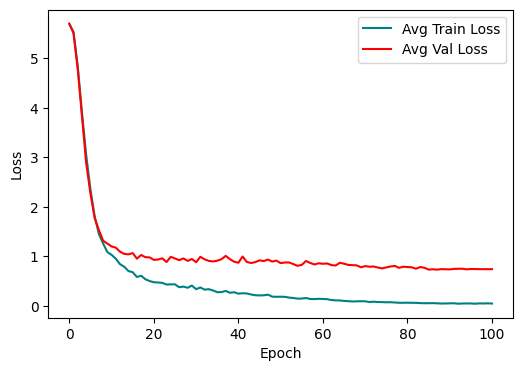

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(clear_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(clear_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on FaceScrub with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

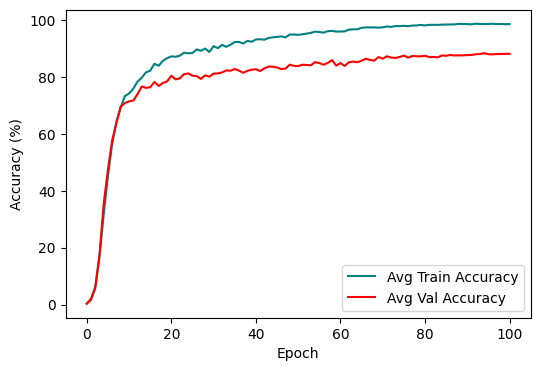

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(clear_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(clear_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on FaceScrub with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot blur loss and accuracy

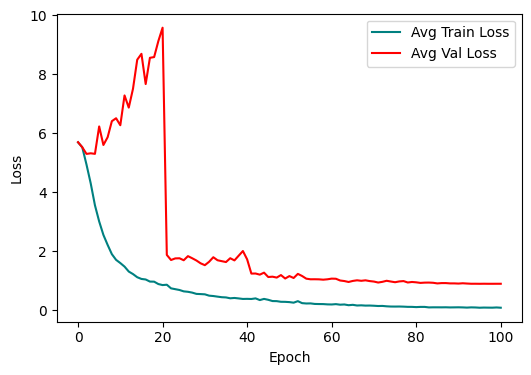

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on FaceScrub Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

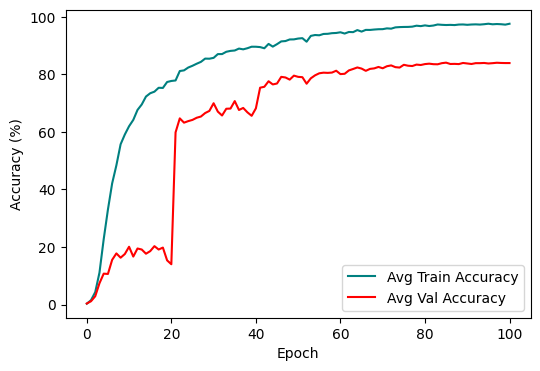

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on FaceScrub Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Facescrub full blur training

In [ ]:
learning_rate = 0.001
epochs = 50
batch_size = 256
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/facescrub_full_blur"

os.makedirs(output_dir, exist_ok=True)

### Define transforms

In [ ]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import FaceScrubDataset, FACESCRUB_MEAN, FACESCRUB_STD
from torch.utils.data import DataLoader

prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load FaceScrub dataset

In [ ]:
train_dataset = FaceScrubDataset(train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = FaceScrubDataset(train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = FaceScrubDataset(train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Dev set size: 23488
Val set size: 2936
Test set size: 2936


In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_model = AlexNetSup(num_classes=297).to(device)

criterion = nn.CrossEntropyLoss()
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)

blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
blur_train_correct, blur_val_correct = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs = []

blur_model.eval()

# Training metrics initialization
blur_train_corr, total_train = 0, 0
blur_train_loss = 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        blur_y_pred = blur_model(images)

        # Calculate loss values
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
blur_train_accuracy = (blur_train_corr / total_train) * 100
blur_train_loss /= total_train

# Validation metrics initialization
blur_val_corr, total_val = 0, 0
blur_val_loss = 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
blur_val_accuracy = (blur_val_corr / total_val) * 100
blur_val_loss /= total_val

# Save results for plotting
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
blur_train_loss_list.append(blur_train_loss)
blur_val_loss_list.append(blur_val_loss)

blur_log_entry = (f"Epoch 0/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs.append(blur_log_entry)

Epoch 0/50, Train acc: 0.3434%, Train loss: 5.6966, Val acc: 0.57%, Val loss: 5.6974


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss_avg:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/50, Train acc: 1.8630%, Train loss: 5.4833, Val acc: 1.88%, Val loss: 5.4941
Epoch 2/50, Train acc: 5.0438%, Train loss: 4.9134, Val acc: 4.87%, Val loss: 4.9066
Epoch 3/50, Train acc: 11.2680%, Train loss: 4.2999, Val acc: 11.47%, Val loss: 4.2885
Epoch 4/50, Train acc: 22.5275%, Train loss: 3.5985, Val acc: 22.66%, Val loss: 3.5265
Epoch 5/50, Train acc: 32.4734%, Train loss: 3.0204, Val acc: 33.42%, Val loss: 2.9689
Epoch 6/50, Train acc: 42.5438%, Train loss: 2.5316, Val acc: 41.02%, Val loss: 2.5957
Epoch 7/50, Train acc: 47.0982%, Train loss: 2.2891, Val acc: 46.13%, Val loss: 2.3374
Epoch 8/50, Train acc: 54.5458%, Train loss: 1.9418, Val acc: 53.27%, Val loss: 2.0640
Epoch 9/50, Train acc: 57.4090%, Train loss: 1.8197, Val acc: 54.97%, Val loss: 1.9602
Epoch 10/50, Train acc: 61.8261%, Train loss: 1.5902, Val acc: 56.53%, Val loss: 1.8595
Epoch 11/50, Train acc: 64.8094%, Train loss: 1.4539, Val acc: 59.27%, Val loss: 1.7471
Epoch 12/50, Train acc: 68.0203%, Train loss:

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(blur_metrics, metrics_file)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Plot loss and accuracy

In [ ]:
import pickle

output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/facescrub_full_blur"

with open(f"{output_dir}/metrics.pkl", "rb") as metrics_file:
    blur_metrics = pickle.load(metrics_file)

blur_train_correct = blur_metrics['blur_train_correct']
blur_val_correct = blur_metrics['blur_val_correct']
blur_train_loss_list = blur_metrics['blur_train_loss_list']
blur_val_loss_list = blur_metrics['blur_val_loss_list']

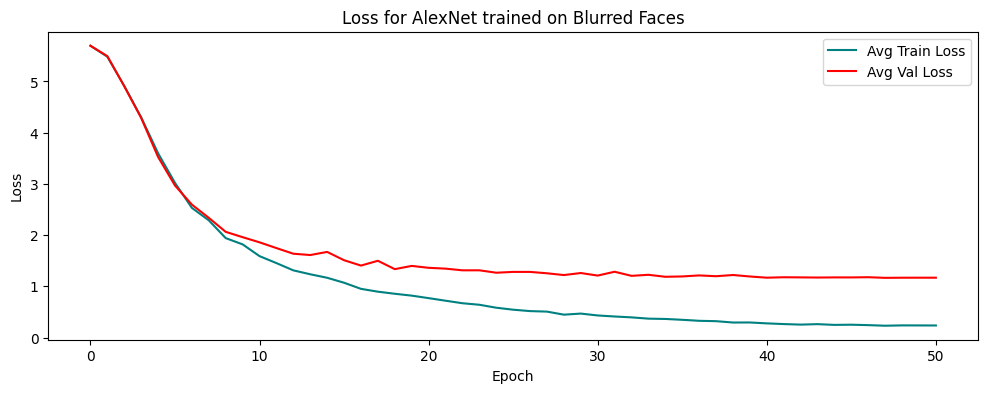

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on Blurred Faces')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

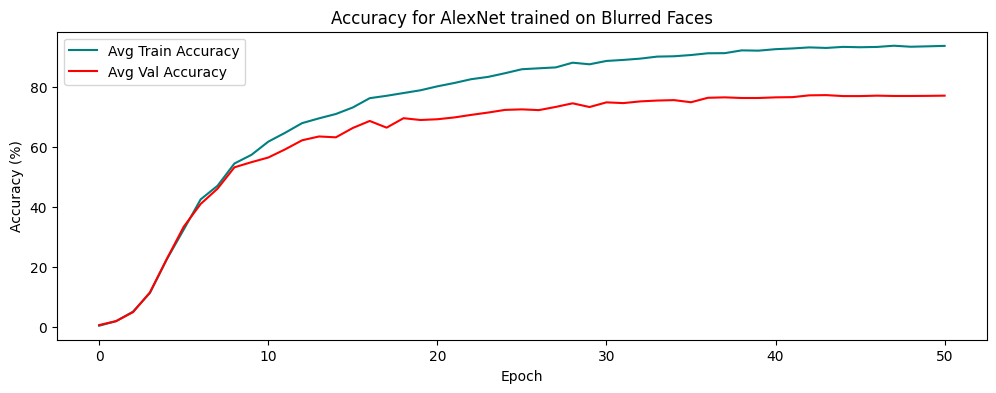

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on Blurred Faces')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Continue training blurry to 100 epochs

In [ ]:
learning_rate = 0.001
epochs = 100
batch_size = 256
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/facescrub_full_blur"

os.makedirs(output_dir, exist_ok=True)

import numpy as np
import torchvision.transforms.v2 as v2
from datasets import FaceScrubDataset, FACESCRUB_MEAN, FACESCRUB_STD
from torch.utils.data import DataLoader

prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
])

train_dataset = FaceScrubDataset(train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = FaceScrubDataset(train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = FaceScrubDataset(train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_model = AlexNetSup(num_classes=297).to(device)

criterion = nn.CrossEntropyLoss()
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)

blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

import re
import os
import torch
from utils import add_blur_with

text = """
Epoch 0/50, Train acc: 0.3434%, Train loss: 5.6966, Val acc: 0.57%, Val loss: 5.6974
Epoch 1/50, Train acc: 1.8630%, Train loss: 5.4833, Val acc: 1.88%, Val loss: 5.4941
Epoch 2/50, Train acc: 5.0438%, Train loss: 4.9134, Val acc: 4.87%, Val loss: 4.9066
Epoch 3/50, Train acc: 11.2680%, Train loss: 4.2999, Val acc: 11.47%, Val loss: 4.2885
Epoch 4/50, Train acc: 22.5275%, Train loss: 3.5985, Val acc: 22.66%, Val loss: 3.5265
Epoch 5/50, Train acc: 32.4734%, Train loss: 3.0204, Val acc: 33.42%, Val loss: 2.9689
Epoch 6/50, Train acc: 42.5438%, Train loss: 2.5316, Val acc: 41.02%, Val loss: 2.5957
Epoch 7/50, Train acc: 47.0982%, Train loss: 2.2891, Val acc: 46.13%, Val loss: 2.3374
Epoch 8/50, Train acc: 54.5458%, Train loss: 1.9418, Val acc: 53.27%, Val loss: 2.0640
Epoch 9/50, Train acc: 57.4090%, Train loss: 1.8197, Val acc: 54.97%, Val loss: 1.9602
Epoch 10/50, Train acc: 61.8261%, Train loss: 1.5902, Val acc: 56.53%, Val loss: 1.8595
Epoch 11/50, Train acc: 64.8094%, Train loss: 1.4539, Val acc: 59.27%, Val loss: 1.7471
Epoch 12/50, Train acc: 68.0203%, Train loss: 1.3122, Val acc: 62.29%, Val loss: 1.6369
Epoch 13/50, Train acc: 69.6214%, Train loss: 1.2359, Val acc: 63.57%, Val loss: 1.6115
Epoch 14/50, Train acc: 71.0766%, Train loss: 1.1675, Val acc: 63.28%, Val loss: 1.6721
Epoch 15/50, Train acc: 73.2572%, Train loss: 1.0706, Val acc: 66.41%, Val loss: 1.5103
Epoch 16/50, Train acc: 76.3607%, Train loss: 0.9513, Val acc: 68.75%, Val loss: 1.4055
Epoch 17/50, Train acc: 77.1592%, Train loss: 0.8960, Val acc: 66.51%, Val loss: 1.4992
Epoch 18/50, Train acc: 78.0778%, Train loss: 0.8553, Val acc: 69.67%, Val loss: 1.3360
Epoch 19/50, Train acc: 78.9964%, Train loss: 0.8187, Val acc: 69.07%, Val loss: 1.3991
Epoch 20/50, Train acc: 80.3142%, Train loss: 0.7701, Val acc: 69.32%, Val loss: 1.3621
Epoch 21/50, Train acc: 81.4303%, Train loss: 0.7197, Val acc: 69.92%, Val loss: 1.3458
Epoch 22/50, Train acc: 82.7009%, Train loss: 0.6706, Val acc: 70.77%, Val loss: 1.3130
Epoch 23/50, Train acc: 83.4693%, Train loss: 0.6407, Val acc: 71.56%, Val loss: 1.3132
Epoch 24/50, Train acc: 84.6969%, Train loss: 0.5830, Val acc: 72.44%, Val loss: 1.2663
Epoch 25/50, Train acc: 86.0276%, Train loss: 0.5443, Val acc: 72.62%, Val loss: 1.2821
Epoch 26/50, Train acc: 86.3410%, Train loss: 0.5170, Val acc: 72.37%, Val loss: 1.2821
Epoch 27/50, Train acc: 86.6372%, Train loss: 0.5069, Val acc: 73.44%, Val loss: 1.2551
Epoch 28/50, Train acc: 88.2126%, Train loss: 0.4472, Val acc: 74.64%, Val loss: 1.2204
Epoch 29/50, Train acc: 87.6803%, Train loss: 0.4685, Val acc: 73.40%, Val loss: 1.2602
Epoch 30/50, Train acc: 88.7964%, Train loss: 0.4318, Val acc: 74.96%, Val loss: 1.2104
Epoch 31/50, Train acc: 89.1398%, Train loss: 0.4117, Val acc: 74.72%, Val loss: 1.2851
Epoch 32/50, Train acc: 89.5733%, Train loss: 0.3945, Val acc: 75.28%, Val loss: 1.2052
Epoch 33/50, Train acc: 90.2473%, Train loss: 0.3697, Val acc: 75.57%, Val loss: 1.2256
Epoch 34/50, Train acc: 90.3632%, Train loss: 0.3635, Val acc: 75.71%, Val loss: 1.1868
Epoch 35/50, Train acc: 90.7752%, Train loss: 0.3470, Val acc: 75.00%, Val loss: 1.1934
Epoch 36/50, Train acc: 91.3590%, Train loss: 0.3276, Val acc: 76.49%, Val loss: 1.2134
Epoch 37/50, Train acc: 91.4020%, Train loss: 0.3202, Val acc: 76.63%, Val loss: 1.1979
Epoch 38/50, Train acc: 92.3292%, Train loss: 0.2940, Val acc: 76.42%, Val loss: 1.2214
Epoch 39/50, Train acc: 92.2390%, Train loss: 0.2950, Val acc: 76.42%, Val loss: 1.1926
Epoch 40/50, Train acc: 92.7284%, Train loss: 0.2774, Val acc: 76.63%, Val loss: 1.1692
Epoch 41/50, Train acc: 92.9773%, Train loss: 0.2638, Val acc: 76.70%, Val loss: 1.1776
Epoch 42/50, Train acc: 93.3207%, Train loss: 0.2532, Val acc: 77.31%, Val loss: 1.1750
Epoch 43/50, Train acc: 93.1447%, Train loss: 0.2621, Val acc: 77.38%, Val loss: 1.1721
Epoch 44/50, Train acc: 93.4967%, Train loss: 0.2478, Val acc: 77.06%, Val loss: 1.1747
Epoch 45/50, Train acc: 93.3765%, Train loss: 0.2513, Val acc: 77.06%, Val loss: 1.1743
Epoch 46/50, Train acc: 93.4753%, Train loss: 0.2429, Val acc: 77.20%, Val loss: 1.1782
Epoch 47/50, Train acc: 93.8831%, Train loss: 0.2315, Val acc: 77.10%, Val loss: 1.1662
Epoch 48/50, Train acc: 93.5440%, Train loss: 0.2380, Val acc: 77.10%, Val loss: 1.1686
Epoch 49/50, Train acc: 93.6813%, Train loss: 0.2372, Val acc: 77.13%, Val loss: 1.1691
Epoch 50/50, Train acc: 93.8316%, Train loss: 0.2363, Val acc: 77.20%, Val loss: 1.1691
"""

pattern_blur = r"Train acc: ([\d.]+)%, Train loss: ([\d.]+), Val acc: ([\d.]+)%, Val loss: ([\d.]+)"
blur_data = re.findall(pattern_blur, text)

blur_train_correct = [float(acc) for acc, _, _, _ in blur_data]
blur_train_loss_list = [float(loss) for _, loss, _, _ in blur_data]
blur_val_correct = [float(val_acc) for _, _, val_acc, _ in blur_data]
blur_val_loss_list = [float(val_loss) for _, _, _, val_loss in blur_data]

# Split the text into individual lines
logs = text.strip().split("\n")

resume_epoch = 50
blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{resume_epoch}.pth')

if os.path.exists(blur_checkpoint_path):
    print(f"Loading checkpoint from epoch {resume_epoch}...")
    blur_checkpoint = torch.load(blur_checkpoint_path, map_location=device)

    # Load model and optimizer states
    blur_model.load_state_dict(blur_checkpoint['model_state_dict'])
    blur_optimizer.load_state_dict(blur_checkpoint['optimizer_state_dict'])

    # Update starting epoch from the checkpoint
    start_epoch = blur_checkpoint.get('epoch', resume_epoch)
    print(f"Successfully resumed training from epoch {start_epoch}.")
else:
    print("Checkpoint not found, starting from scratch.")
    start_epoch = 0

# Set model to evaluation mode to verify weights are loaded correctly
blur_model.eval()

# Run a quick validation check
blur_val_corr, total_val = 0, 0
with torch.no_grad():
    for _, images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        blur_pred = blur_model(images)
        blur_predicted = torch.max(blur_pred, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

blur_val_acc = (blur_val_corr / total_val) * 100
print(f"Validation Accuracy after checkpoint load - Blur Model: {blur_val_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Dev set size: 23488
Val set size: 2936
Test set size: 2936
Loading checkpoint from epoch 50...
Successfully resumed training from epoch 50.
Validation Accuracy after checkpoint load - Blur Model: 77.20%


In [ ]:
for epoch in range(start_epoch, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        scheduler.step()
        #blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss_avg:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 51/100, Train acc: 93.6255%, Train loss: 0.2440, Val acc: 77.20%, Val loss: 1.1691
Epoch 52/100, Train acc: 93.7285%, Train loss: 0.2377, Val acc: 77.20%, Val loss: 1.1691
Epoch 53/100, Train acc: 93.6513%, Train loss: 0.2423, Val acc: 77.20%, Val loss: 1.1691
Epoch 54/100, Train acc: 93.4796%, Train loss: 0.2457, Val acc: 77.20%, Val loss: 1.1691
Epoch 55/100, Train acc: 93.5783%, Train loss: 0.2382, Val acc: 77.20%, Val loss: 1.1691
Epoch 56/100, Train acc: 93.4839%, Train loss: 0.2411, Val acc: 77.20%, Val loss: 1.1691
Epoch 57/100, Train acc: 93.4796%, Train loss: 0.2475, Val acc: 77.20%, Val loss: 1.1691
Epoch 58/100, Train acc: 93.6813%, Train loss: 0.2393, Val acc: 77.20%, Val loss: 1.1691
Epoch 59/100, Train acc: 93.6470%, Train loss: 0.2441, Val acc: 77.20%, Val loss: 1.1691
Epoch 60/100, Train acc: 93.7843%, Train loss: 0.2389, Val acc: 77.20%, Val loss: 1.1691
Epoch 61/100, Train acc: 93.7285%, Train loss: 0.2324, Val acc: 77.20%, Val loss: 1.1691
Epoch 62/100, Train a

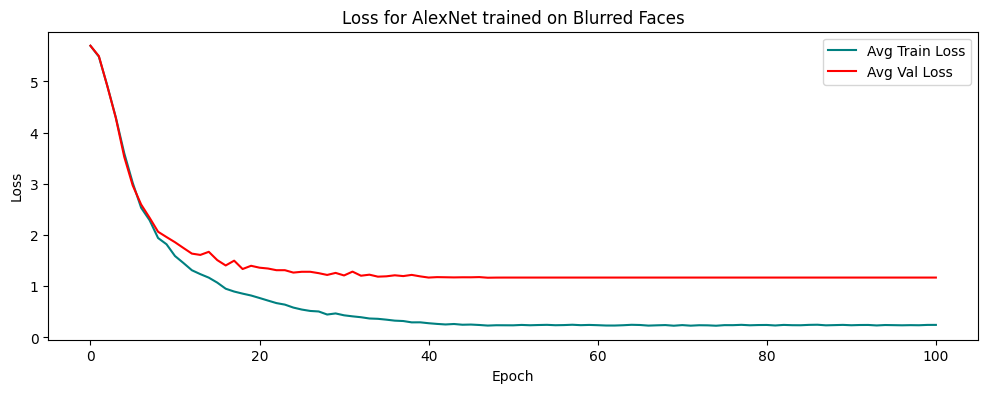

In [ ]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(blur_metrics, metrics_file)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on Blurred Faces')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
import pickle

output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/facescrub_full_blur"

with open(f"{output_dir}/metrics.pkl", "rb") as metrics_file:
    blur_metrics = pickle.load(metrics_file)

blur_train_correct = blur_metrics['blur_train_correct']
blur_val_correct = blur_metrics['blur_val_correct']
blur_train_loss_list = blur_metrics['blur_train_loss_list']
blur_val_loss_list = blur_metrics['blur_val_loss_list']

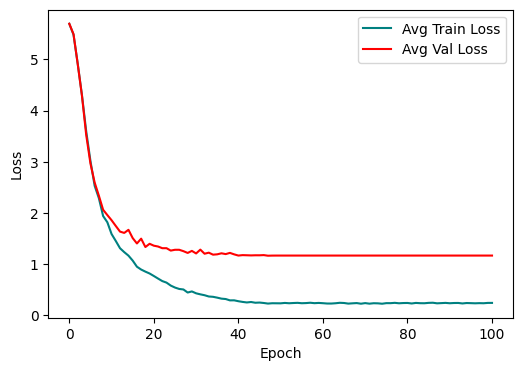

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on Blurred Faces')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

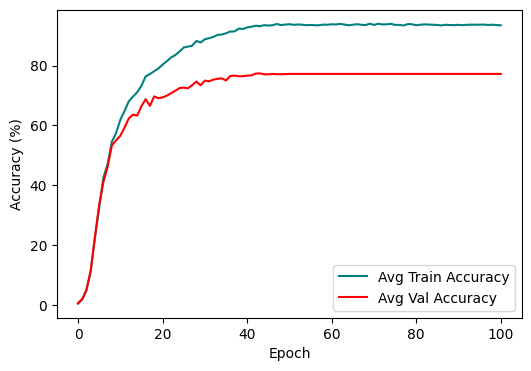

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on Blurred Faces')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()